In [1]:
from torchvision.transforms import ToTensor,ToPILImage
import numpy as np
from keras.datasets import mnist
import os
from PIL import Image

# load data

Why I dont use the whole dataset is because the size of the input of AlexNet is 224 which is very big compared to the imgs from minist dataset and the ram storage of google colab is too small :(

In [38]:
#create directory to store mnist dataset
path = './mnist_datasets/'
if not os.path.exists('./mnist_datasets/'):
  os.makedirs(path)
  os.makedirs(os.path.join(path, 'x_train/'))
  os.makedirs(os.path.join(path, 'x_test/'))
  os.makedirs(os.path.join(path, 'x_noisy_train/'))
  os.makedirs(os.path.join(path, 'x_noisy_test/'))  

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:10000,:,:]
x_test = x_test[:1000,:,:]
y_train = y_train[:10000]
y_test = y_test[:1000]

# adding noise

In [3]:
noise_factor = 0.8
x_train = x_train/255
x_test = x_test/255
x_noisy_train = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_noisy_test = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_noisy_train = np.clip(x_noisy_train, 0., 1.)
x_noisy_test = np.clip(x_noisy_test, 0., 1.)

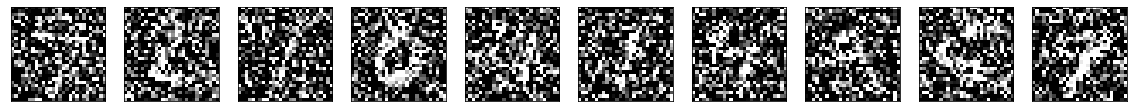

In [4]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_noisy_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# img resize
since our model is Alexnet and the input size should be 224*224, we need to resize our model from 28 to 224

In [5]:
from keras.preprocessing.image import img_to_array, array_to_img

img_size = 224 #img_size we want to convert to

X_train = np.zeros([len(x_train),img_size,img_size],dtype='float32')
X_test = np.zeros([len(x_test),img_size,img_size],dtype='float32')
X_noisy_train = np.zeros([len(x_train),img_size,img_size],dtype='float32')
X_noisy_test = np.zeros([len(x_test),img_size,img_size],dtype='float32')

for index in range(0, len(x_train)):
  x = np.expand_dims(x_train[index], axis=2)
  x = array_to_img(x)
  img = x.resize((img_size,img_size))
  image_path = "./mnist_datasets/x_train/{}.jpg".format(index+1)
  img.save(image_path)
  img_arr = np.array(img, dtype='float32')
  X_train[index] = img_arr/255

for index in range(0, len(x_test)):
  x = np.expand_dims(x_test[index], axis=2)
  x = array_to_img(x)
  img = x.resize((img_size,img_size))
  image_path = "./mnist_datasets/x_test/{}.jpg".format(index+1)
  img.save(image_path)
  img_arr = np.array(img, dtype='float32')
  X_test[index] = img_arr/255

for index in range(0, len(x_noisy_train)):
  x = np.expand_dims(x_noisy_train[index], axis=2)
  x = array_to_img(x)
  img = x.resize((img_size,img_size))
  image_path = "./mnist_datasets/x_noisy_train/{}.jpg".format(index+1)
  img.save(image_path)
  img_arr = np.array(img, dtype='float32')
  X_noisy_train[index] = img_arr/255

for index in range(0, len(x_noisy_test)):
  x = np.expand_dims(x_noisy_test[index], axis=2)
  x = array_to_img(x)
  img = x.resize((img_size,img_size))
  image_path = "./mnist_datasets/x_noisy_test/{}.jpg".format(index+1)
  img.save(image_path)
  img_arr = np.array(img, dtype='float32')
  X_noisy_test[index] = img_arr/255

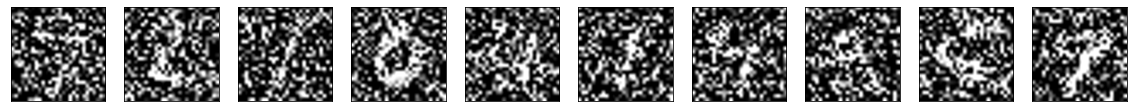

In [6]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X_noisy_test[i].reshape(img_size, img_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# construct AlexNet based auto encoder

In [7]:
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose, Input, UpSampling2D
import keras
from keras.layers.normalization import BatchNormalization

input_img = Input(shape=(img_size, img_size, 1))
encoder = Sequential()
#1st Convolutional Layer
encoder.add(Conv2D(filters=96, input_shape=(img_size,img_size,1), kernel_size=(11,11), strides=(4,4), padding='same'))
encoder.add(BatchNormalization())
encoder.add(Activation('relu'))
encoder.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
encoder.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
encoder.add(BatchNormalization())
encoder.add(Activation('relu'))
encoder.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
encoder.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
encoder.add(BatchNormalization())
encoder.add(Activation('relu')) # 2*2*384

#4rd Convolutional Layer
encoder.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
encoder.add(BatchNormalization())
encoder.add(Activation('relu')) # 2*2*384

#5rd Convolutional Layer
encoder.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
encoder.add(BatchNormalization())
encoder.add(Activation('relu'))
encoder.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

encoded = encoder(input_img)

encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        11712     
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)       0

In [8]:
decoder = encoder

#1rd conv and 1st upsampling
decoder.add(Conv2DTranspose(filters=256, kernel_size=(3,3), strides=(1,1), padding='same')) # 1*1*256
decoder.add(BatchNormalization())
decoder.add(Activation('relu'))
decoder.add(UpSampling2D(size=(2, 2)))  # 2*2*256

#2nd conv
decoder.add(Conv2DTranspose(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation('relu')) # 2*2*384

#3rd conv
decoder.add(Conv2DTranspose(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation('relu')) # 2*2*384

#4th conv and 2nd upsampling
decoder.add(Conv2DTranspose(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation('relu'))
decoder.add(UpSampling2D(size=(2, 2)))  # 4*4*256

#5th conv and 3rd upsampling
decoder.add(Conv2DTranspose(filters=96, input_shape=(img_size,img_size,1), kernel_size=(11,11), strides=(4,4), padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation('relu'))
decoder.add(UpSampling2D(size=(2, 2))),
decoder.add(Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid'))

decoded = decoder(input_img)
decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        11712     
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)       0

In [9]:
autoencoder = Model(input_img, decoder(input_img))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [11]:
if not os.path.exists('/content/autoencoder.h5'):
  autoencoder.fit(X_noisy_train, X_train,
                  epochs=100,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(X_noisy_test, X_test))

  autoencoder.save('autoencoder.h5')

Epoch 1/100
79/79 [==============================] - 26s 324ms/step - loss: 0.9681 - val_loss: 0.6683
Epoch 2/100
79/79 [==============================] - 26s 324ms/step - loss: 0.8019 - val_loss: 0.6056
Epoch 3/100
79/79 [==============================] - 26s 324ms/step - loss: 0.6934 - val_loss: 0.5537
Epoch 4/100
79/79 [==============================] - 26s 325ms/step - loss: 0.6196 - val_loss: 0.5125
Epoch 5/100
79/79 [==============================] - 26s 325ms/step - loss: 0.5656 - val_loss: 0.4891
Epoch 6/100
79/79 [==============================] - 26s 324ms/step - loss: 0.5241 - val_loss: 0.4910
Epoch 7/100
79/79 [==============================] - 26s 324ms/step - loss: 0.4922 - val_loss: 0.4884
Epoch 8/100
79/79 [==============================] - 26s 325ms/step - loss: 0.4665 - val_loss: 0.4725
Epoch 9/100
79/79 [==============================] - 26s 325ms/step - loss: 0.4456 - val_loss: 0.4519
Epoch 10/100
79/79 [==============================] - 26s 325ms/step - loss: 0.428

In [12]:
auto_encoder = load_model('autoencoder.h5')
X_denoising_train = auto_encoder.predict(X_noisy_train)
X_denoising_test = auto_encoder.predict(X_noisy_test)

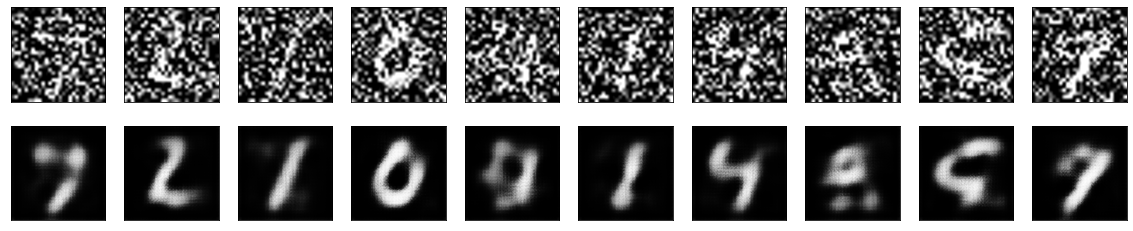

In [16]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_noisy_test[i].reshape(224, 224))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_denoising_test[i].reshape(224, 224))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# classification

After we denoising our noisy data sets, we put these decoded img into another alexnet model to do classification.

In [35]:
np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(img_size,img_size,1), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Fully Connected layer
AlexNet.add(Flatten())

# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(img_size,img_size,1,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(10))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()
AlexNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 56, 56, 96)        11712     
_________________________________________________________________
batch_normalization_55 (Batc (None, 56, 56, 96)        384       
_________________________________________________________________
activation_55 (Activation)   (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_56 (Batc (None, 28, 28, 256)       1024      
_________________________________________________________________
activation_56 (Activation)   (None, 28, 28, 256)      

Using one-hot encoding because the last layer of alexnet model is a softmax which return the probability of the input on 10 classes.

In [39]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [40]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
AlexNet.fit(X_denoising_train, y_train,
                epochs=50,
                batch_size=128,
                shuffle=True,              
                validation_data=(X_denoising_test, y_test))

Epoch 1/50
 1/79 [..............................] - ETA: 10s - loss: 2.6684 - accuracy: 0.1172

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


79/79 [==============================] - 7s 92ms/step - loss: 0.8799 - accuracy: 0.6867 - val_loss: 1.0865 - val_accuracy: 0.6630
Epoch 2/50
79/79 [==============================] - 7s 91ms/step - loss: 0.6583 - accuracy: 0.8432 - val_loss: 1.3330 - val_accuracy: 0.6160
Epoch 3/50
79/79 [==============================] - 8s 97ms/step - loss: 0.5930 - accuracy: 0.8579 - val_loss: 1.1379 - val_accuracy: 0.6570
Epoch 4/50
79/79 [==============================] - 7s 94ms/step - loss: 0.5613 - accuracy: 0.8540 - val_loss: 0.7693 - val_accuracy: 0.7730
Epoch 5/50
79/79 [==============================] - 7s 92ms/step - loss: 0.4985 - accuracy: 0.8769 - val_loss: 0.6316 - val_accuracy: 0.8150
Epoch 6/50
79/79 [==============================] - 7s 94ms/step - loss: 0.4595 - accuracy: 0.8868 - val_loss: 0.6796 - val_accuracy: 0.7930
Epoch 7/50
79/79 [==============================] - 7s 94ms/step - loss: 0.4353 - accuracy: 0.8946 - val_loss: 0.6391 - val_accuracy: 0.8100
Epoch 8/50
79/79 [======

In [41]:
AlexNet.save('AlexNet.h5')

 
only 80%, I think the problem is I didnt use the whole dataset for training to save the runnning time.


In [42]:
classifier = load_model('AlexNet.h5')
scores = classifier.evaluate(X_denoising_test, y_test, verbose=0)
print("Error: %.2f%%" % (100-scores[1]*100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Error: 21.80%


convert softmax probability vector into a label  

In [116]:
#the input should be 4 dimension, if you want to predict label for an image, you need to reshape it into(1, 224, 224, 1) firstv
def softmax2label(prediction):
  max_value = 0
  max_index = 0
  for index, value in enumerate(prediction):
    if value>max_value: 
      max_index = index
      max_value = value
  return max_index

# making prediction

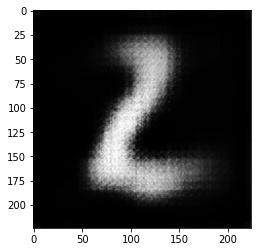

The prediction result is 2






/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [120]:
plt.figure(figsize=(20, 4))
plt.imshow(X_denoising_test[1].reshape(224, 224))
plt.show()
#print prediction result
print('The prediction result is {}\n\n\n\n'.format(softmax2label(classifier.predict(X_denoising_test[1].reshape(1,224,224,1))[0])))